In [20]:
import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.utils.mem import *

from torchvision.models import vgg16_bn

In [29]:
path = untar_data(URLs.PETS)
path_hr = path/'images'
path_lr = path/'small-96'
path_mr = path/'small-256'

In [30]:
path

PosixPath('/home/vishaladu/.fastai/data/oxford-iiit-pet')

In [31]:
il = ImageList.from_folder(path_hr)

In [23]:
def resize_one(fn, i, path, size):
    dest = path/fn.relative_to(path_hr)
    dest.parent.mkdir(parents=True, exist_ok=True)
    img = PIL.Image.open(fn)
    targ_sz = resize_to(img, size, use_min=True)
    img = img.resize(targ_sz, resample=PIL.Image.BILINEAR).convert('RGB')
    img.save(dest, quality=60)

In [33]:
# create smaller image sets the first time this nb is run
sets = [(path_lr, 96), (path_mr, 256)]
for p,size in sets:
    if not p.exists(): 
        print(f"resizing to {size} into {p}")
        parallel(partial(resize_one, path=p, size=size), il.items)

In [34]:
bs,size=32,128
arch = models.resnet34

src = ImageImageList.from_folder(path_lr).split_by_rand_pct(0.1, seed=42)

In [35]:
def get_data(bs,size):
    data = (src.label_from_func(lambda x: path_hr/x.name)
           .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True))

    data.c = 3
    return data

In [36]:
data = get_data(bs, size)

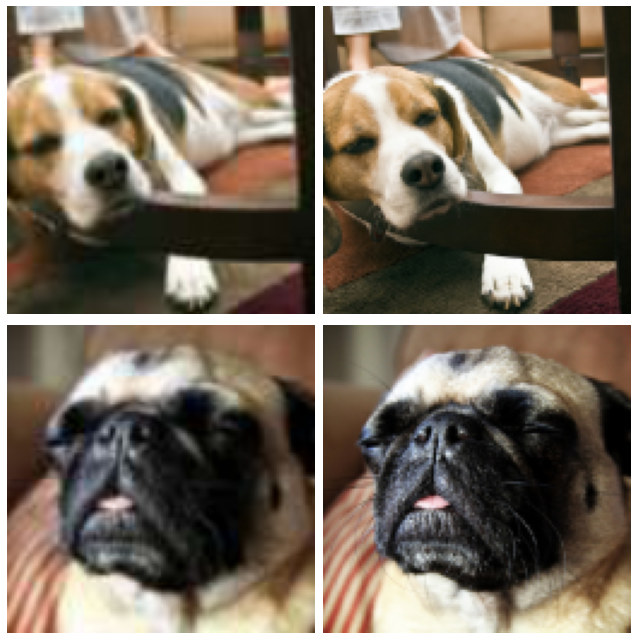

In [37]:
data.show_batch(ds_type=DatasetType.Valid, rows=2, figsize=(9,9))

### Feature Loss

In [43]:
t = data.valid_ds[0][1].data
t = torch.stack([t,t])

In [45]:
def gram_matrix(x):
    n, c, h, w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1, 2)) / (c * h * w)

In [46]:
gram_matrix(t)

tensor([[[0.1049, 0.0930, 0.0800],
         [0.0930, 0.0838, 0.0731],
         [0.0800, 0.0731, 0.0650]],

        [[0.1049, 0.0930, 0.0800],
         [0.0930, 0.0838, 0.0731],
         [0.0800, 0.0731, 0.0650]]])

In [47]:
base_loss = F.l1_loss

In [48]:
#create the vgg_16 model
vgg_m = vgg16_bn(True).features.cuda().eval()
requires_grad(vgg_m, False)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /home/vishaladu/.cache/torch/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 553507836/553507836 [00:41<00:00, 13207498.50it/s]


In [49]:
#Grab the layes before max pool layers
blocks = [i-1 for i,o in enumerate(children(vgg_m)) if isinstance(o, nn.MaxPool2d)]
blocks, [vgg_m[i] for i in blocks]

([5, 12, 22, 32, 42],
 [ReLU(inplace), ReLU(inplace), ReLU(inplace), ReLU(inplace), ReLU(inplace)])

In [50]:
class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel', ] + [f'feat_{i}' for i in range(len(layer_ids))
                                          ] + [f'gram_{i}' for i in range(len(layer_ids))]    

    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        self.feat_losses = [base_loss(input,target)]
        self.feat_losses += [base_loss(f_in, f_out)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()

In [51]:
feat_loss = FeatureLoss(vgg_m, blocks[2:5], [5, 12, 2])

### Train

In [52]:
wd = 1e-3
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, callback_fns=LossMetrics, 
                    blur=True, norm_type=NormType.Weight)

gc.collect()

25074

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


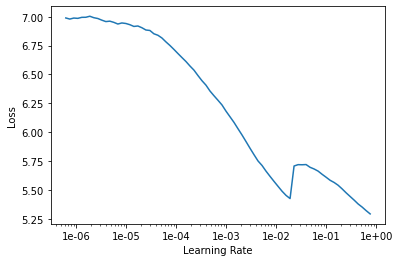

In [53]:
learn.lr_find()
learn.recorder.plot()

In [54]:
lr = 1e-3

In [55]:
def do_fit(save_name, lrs=slice(lr), pct_start=0.9):
    learn.fit_one_cycle(10, lrs, pct_start=pct_start)
    learn.save(save_name)
    learn.show_results(rows=1, imgsize=5)

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,3.375420,3.187713,0.145844,0.228684,0.252478,0.220755,0.549606,0.776310,1.014037,01:02
1,3.268518,3.087753,0.140958,0.225680,0.246965,0.214224,0.525092,0.750842,0.983992,01:01
2,3.216768,3.098390,0.166557,0.225582,0.244891,0.210735,0.534590,0.751511,0.964526,01:01
3,3.189645,2.986634,0.143449,0.225065,0.241713,0.207257,0.492463,0.722634,0.954053,01:01
4,3.156329,2.959405,0.148684,0.222030,0.238366,0.203825,0.494574,0.714555,0.937370,01:01
5,3.116625,2.962696,0.141522,0.223202,0.238991,0.205226,0.489872,0.717040,0.946842,01:01
6,3.075687,2.888584,0.145056,0.220254,0.233271,0.196610,0.485980,0.700365,0.907049,01:01
7,3.049959,2.855782,0.139635,0.220950,0.232816,0.195075,0.472044,0.696126,0.899136,01:01
8,3.020487,2.868011,0.139870,0.220345,0.232249,0.197253,0.473508,0.696556,0.908230,01:02
9,2.949728,2.741318,0.135875,0.217189,0.225954,0.188413,0.439544,0.665969,0.868375,01:02


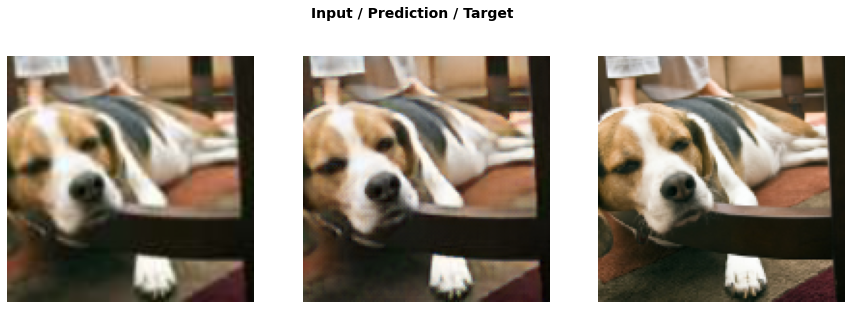

In [56]:
do_fit('1a', slice(lr*10))

In [57]:
learn.unfreeze()

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,2.909739,2.732972,0.135965,0.217032,0.225544,0.187784,0.436770,0.664061,0.865816,01:03
1,2.913218,2.727741,0.135784,0.216815,0.225237,0.187311,0.436234,0.662967,0.863393,01:04
2,2.912210,2.721948,0.135872,0.216396,0.224570,0.186674,0.435233,0.661508,0.861693,01:05
3,2.904002,2.717582,0.136210,0.216475,0.224457,0.186605,0.432600,0.660335,0.860900,01:04
4,2.896697,2.710858,0.136300,0.215937,0.223770,0.186136,0.430370,0.659140,0.859204,01:07
5,2.884532,2.704388,0.135858,0.215370,0.223064,0.185921,0.429779,0.657076,0.857322,01:07
6,2.885180,2.698050,0.136862,0.215259,0.223035,0.185166,0.427789,0.655699,0.854240,01:05
7,2.868801,2.707008,0.135092,0.215317,0.222879,0.185803,0.431621,0.658178,0.858118,01:04
8,2.882169,2.690996,0.136748,0.214096,0.221739,0.185003,0.426089,0.651487,0.855833,01:04
9,2.861656,2.675879,0.135456,0.214237,0.221253,0.183618,0.423617,0.650470,0.847228,01:04


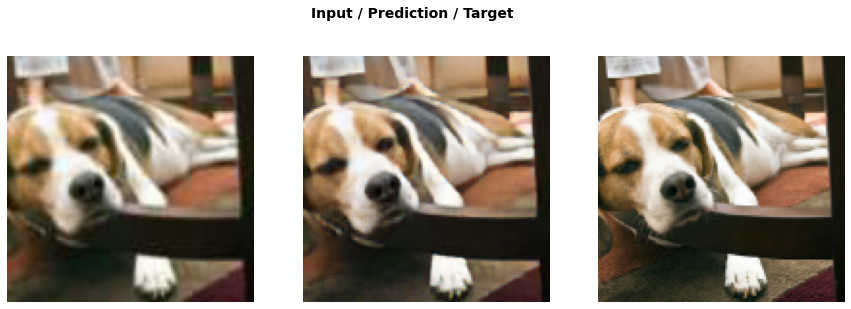

In [58]:
do_fit('1b', slice(1e-5, lr))

In [59]:
data = get_data(12, size*2)

In [60]:
learn.data = data
learn.freeze()
gc.collect()

27027

In [61]:
learn.load('1b')

Learner(data=ImageDataBunch;

Train: LabelList (6651 items)
x: ImageImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
Path: /home/vishaladu/.fastai/data/oxford-iiit-pet/small-96;

Valid: LabelList (739 items)
x: ImageImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
Path: /home/vishaladu/.fastai/data/oxford-iiit-pet/small-96;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): MaxPool2d(kernel_size=3, stride=2,

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,1.981663,1.926465,0.161956,0.259397,0.237667,0.153945,0.384778,0.372792,0.355930,04:05
1,1.942186,1.908453,0.163367,0.259545,0.236155,0.152568,0.376056,0.369019,0.351742,03:56
2,1.922713,1.897518,0.163518,0.260318,0.235170,0.151997,0.369323,0.367262,0.349930,03:56
3,1.903691,1.880745,0.165050,0.261220,0.234025,0.150958,0.359092,0.362871,0.347530,03:56
4,1.887805,1.866901,0.164799,0.258490,0.231732,0.149278,0.357721,0.360273,0.344608,03:57
5,1.875568,1.859294,0.167693,0.258800,0.231383,0.149794,0.348983,0.358480,0.344162,03:57
6,1.858520,1.852260,0.164104,0.258963,0.230882,0.148722,0.348329,0.358126,0.343134,03:58
7,1.848735,1.843636,0.165875,0.256591,0.228104,0.147988,0.348304,0.355658,0.341115,03:58
8,1.855815,1.838415,0.167424,0.256590,0.228185,0.147038,0.347189,0.353009,0.338981,03:58
9,1.819703,1.812478,0.164756,0.256091,0.226625,0.145875,0.334487,0.348759,0.335886,03:58


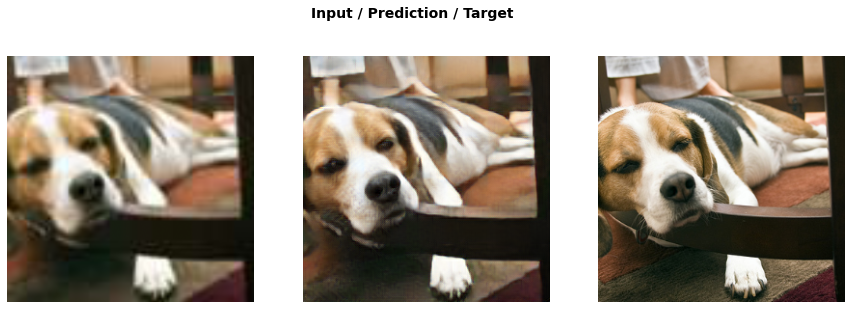

In [62]:
do_fit('2a')

In [63]:
learn.unfreeze()

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,1.827895,1.810722,0.164967,0.256302,0.226605,0.145783,0.333271,0.348089,0.335704,04:05
1,1.818268,1.810290,0.166022,0.257018,0.226834,0.146007,0.331412,0.347535,0.335463,04:06
2,1.825969,1.806339,0.164870,0.256032,0.226248,0.145342,0.332276,0.347040,0.334530,04:06
3,1.825134,1.804551,0.165348,0.256645,0.226536,0.145616,0.329515,0.346836,0.334054,04:06
4,1.810203,1.800327,0.164422,0.255465,0.225647,0.144827,0.330808,0.346020,0.333138,04:06
5,1.814940,1.800553,0.165461,0.256255,0.226125,0.145028,0.328399,0.346108,0.333177,04:06
6,1.807751,1.797764,0.163945,0.255347,0.225491,0.144595,0.329933,0.345823,0.332630,04:06
7,1.814234,1.796269,0.165056,0.255665,0.225493,0.144706,0.328106,0.344820,0.332423,04:08
8,1.802655,1.796636,0.165267,0.255791,0.225703,0.144831,0.327707,0.344819,0.332517,04:07
9,1.809996,1.795703,0.164625,0.255379,0.225338,0.144616,0.328708,0.344804,0.332232,04:06


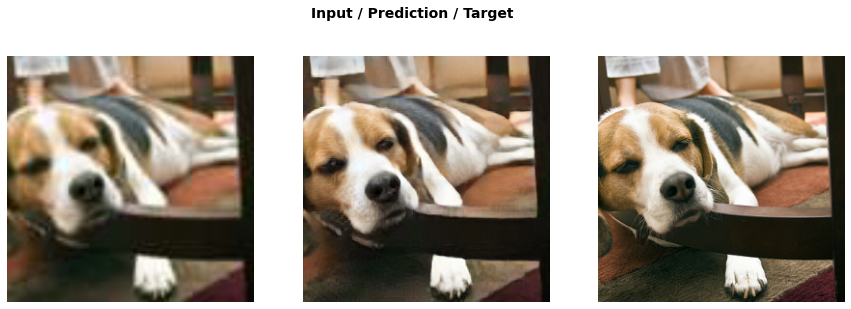

In [64]:
do_fit('2b', slice(1e-6, 1e-4), pct_start=0.3)

In [65]:
learn.path

PosixPath('/home/vishaladu/.fastai/data/oxford-iiit-pet/small-96')

### Test the model

In [66]:
learn = None
gc.collect()

12963

In [67]:
256/320*1024

819.2

In [69]:
256/320*1600

1280.0

In [70]:
free = gpu_mem_get_free_no_cache()
# the max size of the test image depends on the available GPU RAM 
if free > 8000: size=(1280, 1600) # >  8GB RAM
else:           size=( 820, 1024) # <= 8GB RAM
print(f"using size={size}, have {free}MB of GPU RAM free")

using size=(1280, 1600), have 8071MB of GPU RAM free


In [72]:
learn = unet_learner(data, arch, loss_func=F.l1_loss, blur=True,
                    norm_type=NormType.Weight)

In [73]:
data_mr = (ImageImageList.from_folder(path_mr).split_by_rand_pct(0.1, seed=42)
          .label_from_func(lambda x: path_hr/x.name)
          .transform(get_transforms(), size=size, tfm_y=True)
          .databunch(bs=1).normalize(imagenet_stats, do_y=True))
data_mr.c = 3

In [74]:
learn.load('2b')

Learner(data=ImageDataBunch;

Train: LabelList (6651 items)
x: ImageImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
Path: /home/vishaladu/.fastai/data/oxford-iiit-pet/small-96;

Valid: LabelList (739 items)
x: ImageImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
Path: /home/vishaladu/.fastai/data/oxford-iiit-pet/small-96;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): MaxPool2d(kernel_size=3, stride=2,

In [75]:
learn.data = data_mr

In [76]:
fn = data_mr.valid_ds.x.items[0]; fn

PosixPath('/home/vishaladu/.fastai/data/oxford-iiit-pet/small-256/beagle_197.jpg')

In [77]:
img = open_image(fn); img.shape

torch.Size([3, 256, 384])

In [78]:
p, img_hr, b = learn.predict(img)

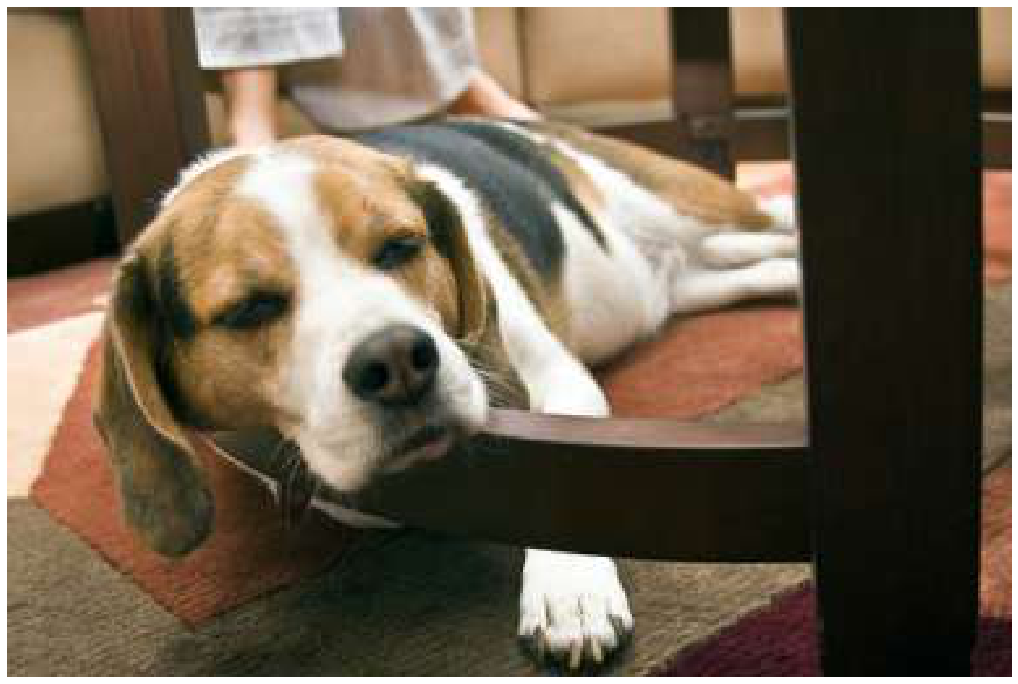

In [79]:
#show grainy image image
show_image(img, figsize=(18,15), interpolation='nearest')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


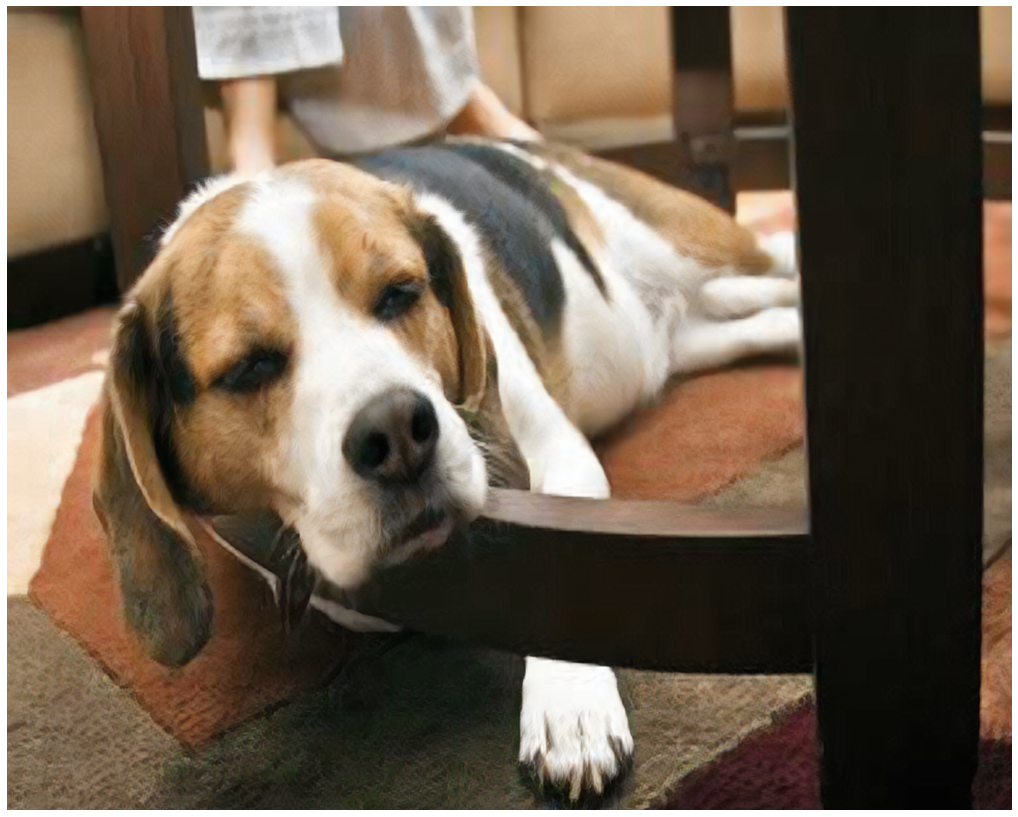

In [81]:
#show superres image
Image(img_hr).show(figsize=(18, 15))